This notebook is going to look at the mistakes made by the chosen model. Specifically, it's going to look at the log loss for each class on the validation set and produce a Hinton diagram for all the classes to show the confusion matrix for this model. Then, it will find the class performing worst and plot example images from this class _after processing_.

Aiming for it to be written in such a way that the model file chosen can just be swapped in, so we can try it on different models.

Setup and prediction
=======

Doing the exact same thing as in the notebook on Holdout set testing, creating a set of predictions:

In [1]:
# copying imports from holdout notebook...
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


In [145]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/alexnet_based_norm_global_8aug.json", settings, force=True)

In [146]:
# loading the model
model = pylearn2.utils.serial.load(run_settings['pickle abspath'])

In [147]:
# loading the data
dataset = neukrill_net.dense_dataset.DensePNGDataset(settings_path=run_settings['settings_path'],
                                            run_settings=run_settings['run_settings_path'],
                                                     train_or_predict='train',
                                                     training_set_mode='validation', force=True)

In [148]:
batch_size=500
while dataset.X.shape[0]%batch_size != 0:
    batch_size += 1
n_batches = int(dataset.X.shape[0]/batch_size)
# set this batch size
model.set_batch_size(batch_size)
# compile Theano function
X = model.get_input_space().make_batch_theano()
Y = model.fprop(X)
f = theano.function([X],Y)

In [149]:
%%time
y = np.zeros((dataset.X.shape[0],len(settings.classes)))
for i in xrange(n_batches):
    print("Batch {0} of {1}".format(i+1,n_batches))
    x_arg = dataset.X[i*batch_size:(i+1)*batch_size,:]
    if X.ndim > 2:
        x_arg = dataset.get_topological_view(x_arg)
    y[i*batch_size:(i+1)*batch_size,:] = (f(x_arg.astype(X.dtype).T))

Batch 1 of 34
Batch 2 of 34
Batch 3 of 34
Batch 4 of 34
Batch 5 of 34
Batch 6 of 34
Batch 7 of 34
Batch 8 of 34
Batch 9 of 34
Batch 10 of 34
Batch 11 of 34
Batch 12 of 34
Batch 13 of 34
Batch 14 of 34
Batch 15 of 34
Batch 16 of 34
Batch 17 of 34
Batch 18 of 34
Batch 19 of 34
Batch 20 of 34
Batch 21 of 34
Batch 22 of 34
Batch 23 of 34
Batch 24 of 34
Batch 25 of 34
Batch 26 of 34
Batch 27 of 34
Batch 28 of 34
Batch 29 of 34
Batch 30 of 34
Batch 31 of 34
Batch 32 of 34
Batch 33 of 34
Batch 34 of 34
CPU times: user 4.77 s, sys: 6.63 s, total: 11.4 s
Wall time: 11.4 s


In [150]:
af = run_settings.get("augmentation_factor",1)
if af > 1:
    y_collapsed = np.zeros((int(dataset.X.shape[0]/af), len(settings.classes))) 
    for i,(low,high) in enumerate(zip(range(0,dataset.y.shape[0],af),
                                      range(af,dataset.y.shape[0]+af,af))):
        y_collapsed[i,:] = np.mean(y[low:high,:], axis=0)
    y = y_collapsed
    labels = dataset.y[range(0,dataset.y.shape[0],af)]
else:
    labels = dataset.y

Log loss by class
======

Creating a bar chart of log loss by class:

In [151]:
import sklearn.metrics

In [152]:
# split predictions by class and calculate log loss
results = {}
uniform = {}
for c in range(121):
    class_mask = labels.ravel() == c
    l = np.zeros(y.shape[0])
    l[np.where(class_mask)] = 1
    p = np.zeros((y.shape[0],2))
    p[:,1] = sum(class_mask)/len(class_mask)
    p[:,0] = 1-p[:,1]
    uniform[c] = sklearn.metrics.log_loss(l,p)
    p[:,1] = y[:,c]
    p[:,0] = 1-p[:,1]
    results[c] = sklearn.metrics.log_loss(l,p)

Comparing the score of the network against a uniform benchmark on a scatter plot:

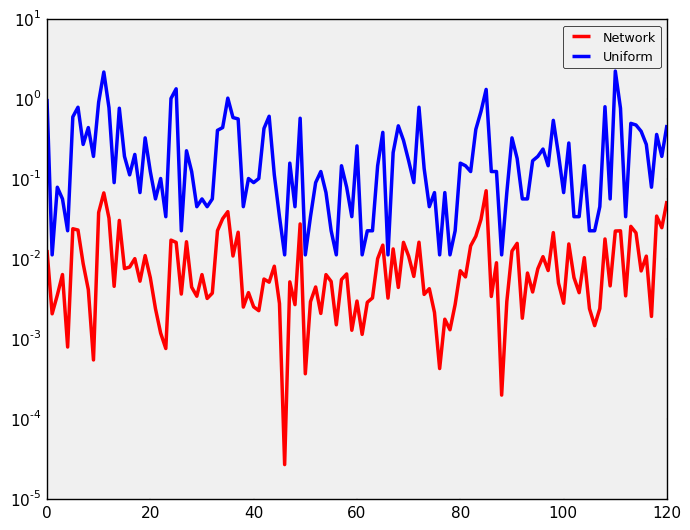

In [153]:
plt.plot(range(121),[results[c] for c in range(121)], c="red", label="Network")
plt.plot(range(121),[uniform[c] for c in range(121)], c="blue", label="Uniform")
plt.yscale("log")
l=plt.legend()

May be better to take the improvement on uniform as a score:

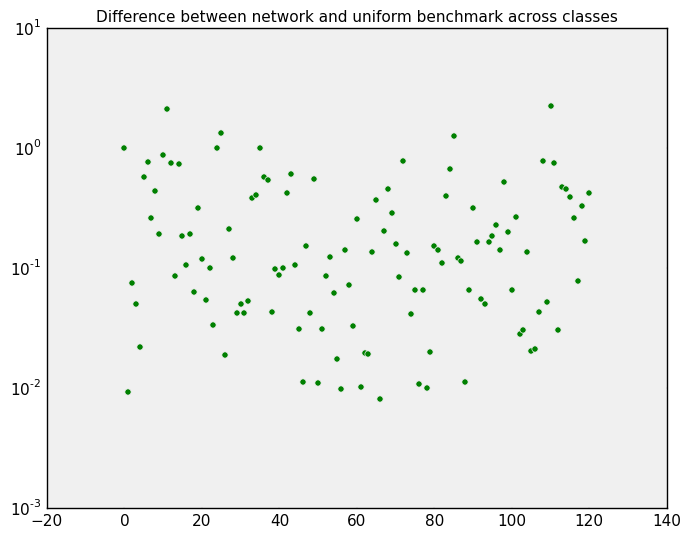

In [154]:
differences = np.array([uniform[c]-results[c] for c in range(121)])
plt.scatter(range(121),differences, c="green")
plt.title("Difference between network and uniform benchmark across classes")
plt.yscale("log")

Finding out which is the worst:

In [155]:
worst = np.where(differences == max(differences))[0][0]
print("Worst performance on: {0}".format(settings.classes[worst]))

Worst performance on: trichodesmium_puff


What's it being confused with?

In [156]:
inds = []
for i,w in enumerate(labels == worst):
    if w:
        r = y[i,:]
        predicted = np.where(r == max(r))[0]
        if predicted != worst:
            inds.append(i)
            print("{0} confused with: {1}".format(settings.classes[worst],
                                                  settings.classes[predicted]))
inds = np.array(inds).ravel()

trichodesmium_puff confused with: trichodesmium_tuft
trichodesmium_puff confused with: trichodesmium_bowtie
trichodesmium_puff confused with: trichodesmium_bowtie
trichodesmium_puff confused with: trichodesmium_bowtie
trichodesmium_puff confused with: trichodesmium_bowtie
trichodesmium_puff confused with: echinoderm_larva_seastar_brachiolaria
trichodesmium_puff confused with: detritus_blob


In [157]:
inds

array([2586, 2614, 2641, 2657, 2686, 2688, 2707])

Plotting example images of this class that were confused with other classes:

In [158]:
example_images = dataset.get_topological_view(dataset.X[inds,:]).reshape(-1,48,48)

Image
      I   : Image.Image   (z)
      II  : Image.Image   (z)
      III : Image.Image   (z)
      IV  : Image.Image   (z)
      V   : Image.Image   (z)
      VI  : Image.Image   (z)
      VII : Image.Image   (z)
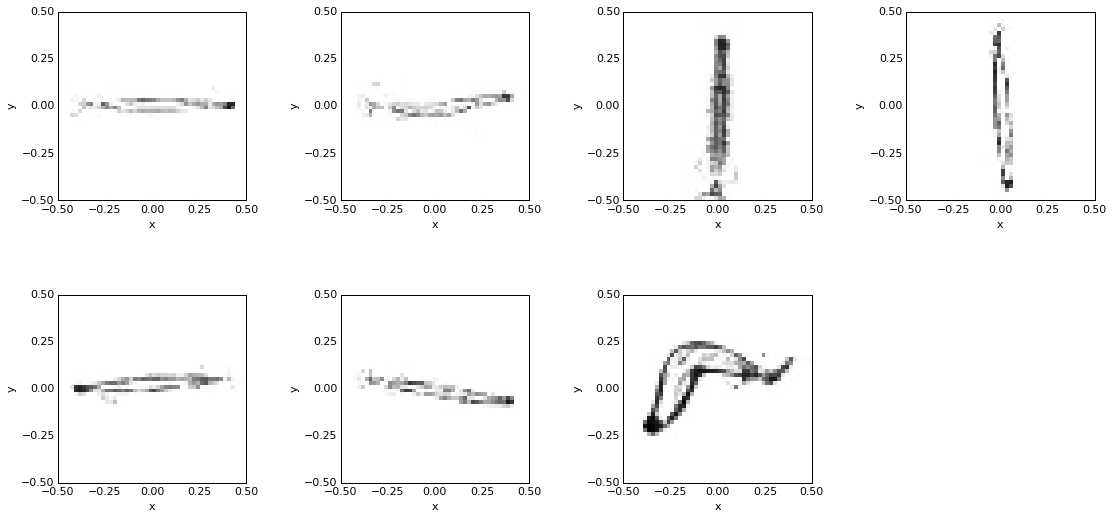

In [159]:
%opts Image style(cmap='gray')
channels = hl.Image(example_images[0,:,:])
for i in example_images[1:,:,:]:
    channels = channels + hl.Image(i)
channels

For those cases, here are example images of the classes being confused with:

In [160]:
confusion = []
for r in y[inds,:]:
    predicted = np.where(r == max(r))[0][0]
    confusion.append(predicted)

In [161]:
confusion

[111, 108, 108, 108, 108, 43, 33]

Image
      Detritus_blob                        
         I  : Image.Image.Detritus_blob   (z)
         II : Image.Image.Detritus_blob   (z)
      Echinoderm_larva_seastar_brachiolaria
         I  : Image.Image.Echinoderm_larva_seastar_brachiolaria   (z)
         II : Image.Image.Echinoderm_larva_seastar_brachiolaria   (z)
      Trichodesmium_bowtie                 
         I  : Image.Image.Trichodesmium_bowtie   (z)
         II : Image.Image.Trichodesmium_bowtie   (z)
      Trichodesmium_tuft                   
         I  : Image.Image.Trichodesmium_tuft   (z)
         II : Image.Image.Trichodesmium_tuft   (z)
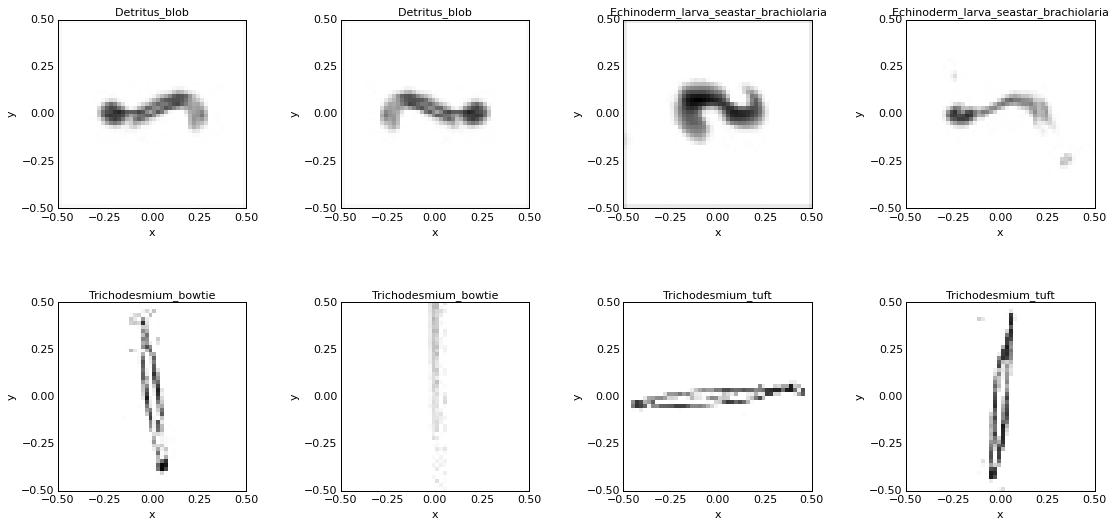

In [177]:
channels = None
for c in list(set(confusion)):
    np.random.seed(42)
    cinds = np.where(labels == c)[0]
    cinds.setflags(write=True)
    np.random.shuffle(cinds)
    cinds = cinds[:4]
    c_examples = dataset.get_topological_view(
                        dataset.X[cinds,:]).reshape(4,48,48)
    cs = str(settings.classes[c])
    cs = cs[:1].upper() + cs[1:]
    for i in range(4):
        if not channels:
            channels = hl.Image(c_examples[i,:,:], label=cs)
        else:
            channels = channels + hl.Image(c_examples[i,:,:], label=cs)
channels